## Динамическое программирование

Рассмотрим алгоритм итерации по оценкам состояния $V$ (Value Iteration):
$$
V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]
$$
На основе оценки $V_i$ можно посчитать функцию оценки $Q_i$ действия $a$ в состоянии $s$:
$$
Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]
$$
$$
V_{(i+1)}(s) = \max_a Q_i(s,a)
$$

Зададим напрямую модель MDP с картинки:
<img src="https://raw.githubusercontent.com/Tviskaron/mipt/master/2019/RL/02/mdp.png" caption="Марковский процесс принятия решений" style="width: 400px;">

In [1]:
# !wget https://raw.githubusercontent.com/Tviskaron/mipt/master/2019/RL/02/mdp.py

In [2]:
transition_probs = {
  's0':{
    'a0': {'s0': 0.5, 's2': 0.5},
    'a1': {'s2': 1}
  },
  's1':{
    'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
    'a1': {'s1': 0.95, 's2': 0.05}
  },
  's2':{
    'a0': {'s0': 0.4, 's2': 0.6},
    'a1': {'s0': 0.3, 's1': 0.3, 's2':0.4}
  }
}
rewards = {
  's1': {'a0': {'s0': +5}},
  's2': {'a1': {'s0': -1}}
}

from mdp import MDP
import numpy as np
mdp = MDP(transition_probs, rewards, initial_state='s0')

Теперь мы можем использовать это MDP, как и любое другое gym окружение:

In [3]:
state = mdp.reset()
print('initial state =', state)
next_state, reward, done, info = mdp.step('a1')
print(f'next_state = {next_state}, reward = {reward}, done = {done}')

initial state = s0
next_state = s2, reward = 0.0, done = False


:Также, помимо стандартных методов, есть дополнительные, которые пригодятся нам для реализации метода итерации по полезностям.

In [4]:
print("all_states =", mdp.get_all_states())
print("possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("reward('s1', 'a0', 's0') = ",mdp.get_reward('s1', 'a0', 's0'))
print("transition_prob('s1', 'a0', 's0') = ",
      mdp.get_transition_prob('s1', 'a0', 's0'))

all_states = ('s0', 's1', 's2')
possible_actions('s1') =  ('a0', 'a1')
next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
reward('s1', 'a0', 's0') =  5
transition_prob('s1', 'a0', 's0') =  0.7


### Задание 1

Теперь реализуем алгоритм итерации по полезностям, чтобы решить этот вручную заданный MDP. Псевдокод алгоритма:

---

`1.` Инициализируем $V^{(0)}(s)=0$, для всех $s$

`2.` For $i=0, 1, 2, \dots$

`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, для всех $s$

---

Вначале вычисляем оценку состояния-действия:
$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$

### 1 балл

In [5]:
def get_action_value(
    mdp, state_values, state, action, gamma
):
    """ Вычисляем Q(s,a) по формуле выше """
    Q = 0
    for next_state, next_state_value in state_values.items():
        prob   = mdp.get_transition_prob(state, action, next_state)
        reward = mdp.get_reward(state, action, next_state)
        value  = gamma * next_state_value
        Q += prob * (reward + value)
    return Q

In [6]:
test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.isclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.isclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

Теперь оцениваем полезность самого состояния, для этого мы можем использовать предыдущий метод:

$$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

### 1 балл

In [7]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Считаем следующее V(s) по формуле выше."""
    if mdp.is_terminal(state):
        return 0
    V = max(
        get_action_value(mdp, state_values, state, action, gamma)
        for action in mdp.get_possible_actions(state)
    )
    return V

In [8]:
test_Vs_copy = dict(test_Vs)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 1.08)
assert np.isclose(get_new_state_value(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9), -13500000000.0), \
   "Убедитесь, что вы правильно обрабатываете отрицательные значения Q произвольной величины."
assert test_Vs == test_Vs_copy, "Убедитесь, что вы не изменяете state_values в функции get_new_state_value"

Теперь создаем основной цикл итерационного оценки полезности состояний с критерием остановки, который проверяет насколько изменились полезности.

### 1 балл

In [9]:
def value_iteration(
    mdp, state_values=None,
    gamma = 0.9, num_iter = 1000, min_difference = 1e-5
):
    """ выполняет num_iter шагов итерации по значениям"""
    # инициализируем V(s)
    state_values = state_values or \
    {s : 0 for s in mdp.get_all_states()}

    for i in range(num_iter):
        # Вычисляем новые полезности состояний,
        # используя функции, определенные выше.
        new_state_values = {
            state: get_new_state_value(mdp, state_values, state, gamma)
            for state in mdp.get_all_states()
        }

        assert isinstance(new_state_values, dict)

        # Считаем разницу
        diff = max(
            abs(new_state_values[s] - state_values[s])
            for s in mdp.get_all_states()
        )

        print(
            f"iter {i:4} | diff: {diff:6.5f} "
            f"| V(start): {new_state_values[mdp._initial_state]:.3f} "
        )

        state_values = new_state_values
        if diff < min_difference:
            print("Принято! Алгоритм сходится!")
            break

    return state_values

state_values = value_iteration(
    mdp, num_iter = 100, min_difference = 0.001
)

iter    0 | diff: 3.50000 | V(start): 0.000 
iter    1 | diff: 0.64500 | V(start): 0.000 
iter    2 | diff: 0.58050 | V(start): 0.581 
iter    3 | diff: 0.43582 | V(start): 0.866 
iter    4 | diff: 0.30634 | V(start): 1.145 
iter    5 | diff: 0.27571 | V(start): 1.421 
iter    6 | diff: 0.24347 | V(start): 1.655 
iter    7 | diff: 0.21419 | V(start): 1.868 
iter    8 | diff: 0.19277 | V(start): 2.061 
iter    9 | diff: 0.17327 | V(start): 2.233 
iter   10 | diff: 0.15569 | V(start): 2.389 
iter   11 | diff: 0.14012 | V(start): 2.529 
iter   12 | diff: 0.12610 | V(start): 2.655 
iter   13 | diff: 0.11348 | V(start): 2.769 
iter   14 | diff: 0.10213 | V(start): 2.871 
iter   15 | diff: 0.09192 | V(start): 2.963 
iter   16 | diff: 0.08272 | V(start): 3.045 
iter   17 | diff: 0.07445 | V(start): 3.120 
iter   18 | diff: 0.06701 | V(start): 3.187 
iter   19 | diff: 0.06031 | V(start): 3.247 
iter   20 | diff: 0.05428 | V(start): 3.301 
iter   21 | diff: 0.04885 | V(start): 3.350 
iter   22 

In [10]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 3.781) < 0.01
assert abs(state_values['s1'] - 7.294) < 0.01
assert abs(state_values['s2'] - 4.202) < 0.01

Final state values: {'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}


По найденным полезностям и зная модель переходов легко найти оптимальную стратегию:
$$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$

### 1 балл

In [11]:
def get_optimal_action(
    mdp, state_values, state, gamma=0.9
):
    """ Находим оптимальное действие, используя формулу выше. """
    if mdp.is_terminal(state): return None

    actions = mdp.get_possible_actions(state)
    i = np.argmax([
        get_action_value(mdp, state_values, state, actions[i], gamma)
        for i in range(len(actions))
    ])
    return actions[i]

In [12]:
assert get_optimal_action(mdp, state_values, 's0', 0.9) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', 0.9) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', 0.9) == 'a1'

assert get_optimal_action(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9) == 'a0', \
    "Убедитесь, что вы правильно обрабатываете отрицательные значения Q произвольной величины."
assert get_optimal_action(mdp, {'s0': -2e10, 's1': 0, 's2': -1e10}, 's0', 0.9) == 'a1', \
    "Убедитесь, что вы правильно обрабатываете отрицательные значения Q произвольной величины."

In [13]:
# Проверим среднее вознаграждение агента

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, 0.9))
    rewards.append(r)

print("average reward: ", np.mean(rewards))

assert(0.40 < np.mean(rewards) < 0.55)

average reward:  0.4704


### Задание 2

Теперь проверим работу итерации по ценностям на классической задаче FrozenLake.

In [14]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()
state_values = value_iteration(mdp)

*FFF
FHFH
FFFH
HFFG

iter    0 | diff: 1.00000 | V(start): 0.000 
iter    1 | diff: 0.90000 | V(start): 0.000 
iter    2 | diff: 0.81000 | V(start): 0.000 
iter    3 | diff: 0.72900 | V(start): 0.000 
iter    4 | diff: 0.65610 | V(start): 0.000 
iter    5 | diff: 0.59049 | V(start): 0.590 
iter    6 | diff: 0.00000 | V(start): 0.590 
Принято! Алгоритм сходится!


Визуализируем нашу стратегию.

In [15]:
def draw_policy(mdp, state_values, gamma=0.9):
    """функция визуализации стратегии"""
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {
        s: get_optimal_action(mdp, state_values, s, gamma)
        for s in states
    }
    plt.imshow(
        V.reshape(w, h),
        cmap='gray', interpolation='none',
        clim=(0, 1)
    )
    ax = plt.gca()
    ax.set_xticks(np.arange(h) - .5)
    ax.set_yticks(np.arange(w) - .5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1),
            'right': (1, 0), 'up': (-1, 0)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,
                     verticalalignment='center',
                     horizontalalignment='center',
                     fontweight='bold')
            a = Pi[y, x]
            if a is None: continue
            u, v = a2uv[a]
            plt.arrow(x, y, u * .3, -v * .3,
                      color='m', head_width=0.1,
                      head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()


after iteration 29
iter    0 | diff: 0.00000 | V(start): 0.198 
Принято! Алгоритм сходится!


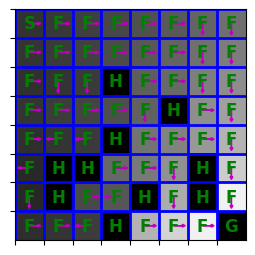

In [16]:
from IPython.display import clear_output
from time import sleep
import matplotlib.pyplot as plt
%matplotlib inline
mdp = FrozenLakeEnv(map_name='8x8',slip_chance=0.1)
state_values = {s : 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i"%i)
    state_values = value_iteration(mdp,
                            state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)

Посмотрим на оптимальную стратегию:

In [17]:
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, 0.9)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break

*FFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

right

S*FFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

right

SF*FFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

right

SFF*FFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

right

SFFF*FFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

right

SFFFF*FF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

right

SFFFFF*F
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

down

SFFFF*FF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

right

SFFFFF*F
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

down

SFFFFFFF
FFFFFF*F
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

down

SFFFFFFF
FFFFFFFF
FFFHFF*F
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

down

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFH*F
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

right

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHF*
FFFHFFFF

Тестируем на более сложном варианте окружения:

### 1 балл

In [18]:
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    state = mdp.reset()
    rewards = []
    for t in range(100):
        action = get_optimal_action(mdp, state_values, state, 0.8)
        next_state, reward, done, _ = mdp.step(action)
        state = next_state
        rewards.append(reward)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("Cреднее вознаграждение:", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Принято!")

iter    0 | diff: 0.80000 | V(start): 0.000 
iter    1 | diff: 0.57600 | V(start): 0.000 
iter    2 | diff: 0.41472 | V(start): 0.000 
iter    3 | diff: 0.29860 | V(start): 0.000 
iter    4 | diff: 0.24186 | V(start): 0.000 
iter    5 | diff: 0.19349 | V(start): 0.000 
iter    6 | diff: 0.15325 | V(start): 0.000 
iter    7 | diff: 0.12288 | V(start): 0.000 
iter    8 | diff: 0.09930 | V(start): 0.000 
iter    9 | diff: 0.08037 | V(start): 0.000 
iter   10 | diff: 0.06426 | V(start): 0.000 
iter   11 | diff: 0.05129 | V(start): 0.000 
iter   12 | diff: 0.04330 | V(start): 0.000 
iter   13 | diff: 0.03802 | V(start): 0.033 
iter   14 | diff: 0.03332 | V(start): 0.058 
iter   15 | diff: 0.02910 | V(start): 0.087 
iter   16 | diff: 0.01855 | V(start): 0.106 
iter   17 | diff: 0.01403 | V(start): 0.120 
iter   18 | diff: 0.00810 | V(start): 0.128 
iter   19 | diff: 0.00555 | V(start): 0.133 
iter   20 | diff: 0.00321 | V(start): 0.137 
iter   21 | diff: 0.00247 | V(start): 0.138 
iter   22 

### Задание 3

Теперь рассмотрим алгоритм итерации по стратегиям (PI, policy iteration):

---
Initialize $\pi_0$   `// случайно`

For $n=0, 1, 2, \dots$
- Считаем функцию $V^{\pi_{n}}$
- Используя $V^{\pi_{n}}$, считаем функцию $Q^{\pi_{n}}$
- Получаем новую стратегию: $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$
---

PI включает в себя оценку полезности состояния, как внутренний шаг.

Вначале оценим полезности, используя текущую стратегию:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$
    Мы будем искать точное решение, хотя могли использовать и предыдущий итерационный подход. Для этого будем решать систему линейных уравнений относительно $V^{\pi}(s_i)$ с помощью np.linalg.solve.

### 3 балла

In [19]:
from numpy.linalg import solve

def compute_vpi(mdp, policy, gamma):
    """
    Считем V^pi(s) для всех состояний, согласно стратегии.
    :param policy: словарь состояние->действие {s : a}
    :returns: словарь {state : V^pi(state)}
    """
    states = mdp.get_all_states()
    n = len(states)
    A, b = [], []
    for i, state in enumerate(states):
        # V(s)
        ohe = np.zeros(n)
        ohe[i] = 1
        if state in policy:
            action = policy[state]
            
            # probabilities
            probs = np.array([
                mdp.get_transition_prob(state, action, next_state)
                for next_state in states
            ])

            # rewards
            rewards = np.array([
                mdp.get_reward(state, action, next_state)
                for next_state in states
            ])
        else:
            probs = np.zeros(n)
            rewards = np.zeros(n)
        row = ohe - gamma * probs
        value = np.dot(probs, rewards)
        A.append(row)
        b.append(value)

    A = np.array(A)
    b = np.array(b)
    values = solve(A, b)

    state_values = {
        states[i] : values[i]
        for i in range(len(states))
    }
    return state_values

In [20]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's1': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}
mdp = MDP(transition_probs, rewards, initial_state='s0')

gamma = 0.9

test_policy = {
    s: np.random.choice(mdp.get_possible_actions(s))
    for s in mdp.get_all_states()}
new_vpi = compute_vpi(mdp, test_policy, gamma)

print(new_vpi)
assert type(new_vpi) is dict, \
    "функция compute_vpi должна возвращать словарь \
    {состояние s : V^pi(s) }"

{'s0': np.float64(-0.8620499834856328), 's1': np.float64(-0.2972586149950459), 's2': np.float64(-0.9578333149840365)}


Теперь обновляем стратегию на основе новых значений полезностей:

### 1 балл

In [21]:
def compute_new_policy(mdp, vpi, gamma):
    """
    Рассчитываем новую стратегию
    :param vpi: словарь {state : V^pi(state) }
    :returns: словарь {state : оптимальное действие}
    """
    Q = {}
    for state in mdp.get_all_states():
        Q[state] = {}
        for a in mdp.get_possible_actions(state):
            values = []
            for next_state in mdp.get_next_states(state, a):
                r = mdp.get_reward(state, a, next_state)
                p = mdp.get_transition_prob(
                    state, a, next_state
                )
                values.append(p * (r + vpi[next_state]))

            Q[state][a] = sum(values)

    policy = {}
    for state in mdp.get_all_states():
        actions = mdp.get_possible_actions(state)
        if actions:
           policy[state] = get_optimal_action(mdp, vpi, state, gamma)

    return policy

In [22]:
new_policy = compute_new_policy(mdp, new_vpi, gamma)

print(new_policy)

assert type(new_policy) is dict, \
"функция compute_new_policy должна возвращать словарь \
{состояние s: оптимальное действие}"

{'s0': 'a0', 's1': 'a0', 's2': 'a0'}


Собираем все в единый цикл:

### 1 балл

In [23]:
def policy_iteration(
    mdp, policy=None, gamma = 0.9,
    num_iter = 1000, min_difference = 1e-5
):
    """
    Запускаем цикл итерации по стратегиям
    Если стратегия не определена, задаем случайную
    """
    for i in range(num_iter):
        if not policy:
            policy = {}
            for s in mdp.get_all_states():
                if mdp.get_possible_actions(s):
                    policy[s] = (
                        np.random.choice(mdp.get_possible_actions(s))
                    )
        vpi = compute_vpi(mdp, policy, gamma)
        policy = compute_new_policy(mdp, vpi, gamma)
    return vpi, policy

Тестируем на FrozenLake.

In [24]:
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values, policy = policy_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(policy[s])
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Принято!")

average reward:  0.875
Принято!
